## Imports

In [2]:
import torch as pt
pt.cuda.is_available()

True

In [3]:
#!pip install dinov2
!pip install --upgrade  git+https://github.com/facebookresearch/dinov2.git

  Cloning https://github.com/facebookresearch/dinov2.git to /tmp/pip-req-build-ndmbozjm
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/dinov2.git /tmp/pip-req-build-ndmbozjm
  fatal: unable to access 'https://github.com/facebookresearch/dinov2.git/': Could not resolve host: github.com
  error: subprocess-exited-with-error
  
  × git clone --filter=blob:none --quiet https://github.com/facebookresearch/dinov2.git /tmp/pip-req-build-ndmbozjm did not run successfully.
  │ exit code: 128
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git clone --filter=blob:none --quiet https://github.com/facebookresearch/dinov2.git /tmp/pip-req-build-ndmbozjm did not run successfully.
│ exit code: 128
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


# Semantic Segmentation

In [3]:
# import sys
# 
# INSTALL = True # Switch this to install dependencies
# if INSTALL: # Try installing package with extras
#     REPO_URL = "https://raw.githubusercontent.com/facebookresearch/dinov2/main/requirements.txt"
#     REPO_EXTRAS = "https://raw.githubusercontent.com/facebookresearch/dinov2/main/requirements-extras.txt"
#     !{sys.executable} -m pip install -r {REPO_URL} --extra-index-url https://download.pytorch.org/whl/cu117  --extra-index-url https://pypi.nvidia.com
#     !{sys.executable} -m pip install -r {REPO_EXTRAS} --extra-index-url https://download.pytorch.org/whl/cu117  --extra-index-url https://pypi.nvidia.com
# else:
#     REPO_PATH = "<FIXME>" # Specify a local path to the repository (or use installed package instead)
#     sys.path.append(REPO_PATH)

## Utilities

In [4]:
import math
import itertools
from functools import partial

import torch
import torch.nn.functional as F
from mmseg.apis import init_segmentor, inference_segmentor

import dinov2.eval.segmentation.models


class CenterPadding(torch.nn.Module):
    def __init__(self, multiple):
        super().__init__()
        self.multiple = multiple

    def _get_pad(self, size):
        new_size = math.ceil(size / self.multiple) * self.multiple
        pad_size = new_size - size
        pad_size_left = pad_size // 2
        pad_size_right = pad_size - pad_size_left
        return pad_size_left, pad_size_right

    @torch.inference_mode()
    def forward(self, x):
        pads = list(itertools.chain.from_iterable(self._get_pad(m) for m in x.shape[:1:-1]))
        output = F.pad(x, pads)
        return output


def create_segmenter(cfg, backbone_model):
    model = init_segmentor(cfg)
    model.backbone.forward = partial(
        backbone_model.get_intermediate_layers,
        n=cfg.model.backbone.out_indices,
        reshape=True,
    )
    if hasattr(backbone_model, "patch_size"):
        model.backbone.register_forward_pre_hook(lambda _, x: CenterPadding(backbone_model.patch_size)(x[0]))
    model.init_weights()
    return model

## Load pretrained backbone

In [5]:
BACKBONE_SIZE = "small" # in ("small", "base", "large" or "giant")


backbone_archs = {
    "small": "vits14",
    "base": "vitb14",
    "large": "vitl14",
    "giant": "vitg14",
}
backbone_arch = backbone_archs[BACKBONE_SIZE]
backbone_name = f"dinov2_{backbone_arch}"

backbone_model = torch.hub.load(repo_or_dir="facebookresearch/dinov2", model=backbone_name)
backbone_model.eval()
backbone_model.cuda()

Using cache found in /home/allshama/.cache/torch/hub/facebookresearch_dinov2_main
/home/allshama/miniconda3/envs/dinov2-gmflow/lib/python3.9/site-packages/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/allshama/miniconda3/envs/dinov2-gmflow/lib/python3.9/site-packages/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/allshama/miniconda3/envs/dinov2-gmflow/lib/python3.9/site-packages/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

## Load pretrained segmentation head

In [6]:
import urllib

import mmcv
from mmcv.runner import load_checkpoint


def load_config_from_url(url: str) -> str:
    with urllib.request.urlopen(url) as f:
        return f.read().decode()


HEAD_SCALE_COUNT = 3 # more scales: slower but better results, in (1,2,3,4,5)
HEAD_DATASET = "voc2012" # in ("ade20k", "voc2012")
HEAD_TYPE = "ms" # in ("ms, "linear")


DINOV2_BASE_URL = "https://dl.fbaipublicfiles.com/dinov2"
head_config_url = f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{HEAD_DATASET}_{HEAD_TYPE}_config.py"
head_checkpoint_url = f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{HEAD_DATASET}_{HEAD_TYPE}_head.pth"

cfg_str = load_config_from_url(head_config_url)
cfg = mmcv.Config.fromstring(cfg_str, file_format=".py")
if HEAD_TYPE == "ms":
    cfg.data.test.pipeline[1]["img_ratios"] = cfg.data.test.pipeline[1]["img_ratios"][:HEAD_SCALE_COUNT]
    print("scales:", cfg.data.test.pipeline[1]["img_ratios"])



scales: [1.0, 1.32, 1.73]


In [12]:
model = create_segmenter(cfg, backbone_model=backbone_model)
load_checkpoint(model, head_checkpoint_url, map_location="cpu")
model.cuda()
model.eval()

/home/allshama/miniconda3/envs/dinov2-gmflow/lib/python3.9/site-packages/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
2024-08-20 11:30:04,830 - mmcv - INFO - initialize BNHead with init_cfg {'type': 'Normal', 'std': 0.01, 'override': {'name': 'conv_seg'}}
2024-08-20 11:30:04,831 - mmcv - INFO - 
decode_head.conv_seg.weight - torch.Size([21, 1536, 1, 1]): 
NormalInit: mean=0, std=0.01, bias=0 
 
2024-08-20 11:30:04,831 - mmcv - INFO - 
decode_head.conv_seg.bias - torch.Size([21]): 
NormalInit: mean=0, std=0.01, bias=0 
 
2024-08-20 11:30:04,832 - mmcv - INFO - 
decode_head.bn.weight - torch.Size([1536]): 
The value is the same before and after calling `init_weights` of EncoderDecoder  
 
2024-08-20 11:30:04,832 - mmcv - INFO - 
decode_head.bn.bias - t

load checkpoint from http path: https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_voc2012_ms_head.pth


EncoderDecoder(
  (backbone): DinoVisionTransformer()
  (decode_head): BNHead(
    input_transform=resize_concat, ignore_index=255, align_corners=False
    (loss_decode): CrossEntropyLoss(avg_non_ignore=False)
    (conv_seg): Conv2d(1536, 21, kernel_size=(1, 1), stride=(1, 1))
    (bn): SyncBatchNorm(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  init_cfg={'type': 'Normal', 'std': 0.01, 'override': {'name': 'conv_seg'}}
)

## Load sample image

In [7]:
import urllib

from PIL import Image


def load_image_from_url(url: str) -> Image:
    with urllib.request.urlopen(url) as f:
        return Image.open(f).convert("RGB")

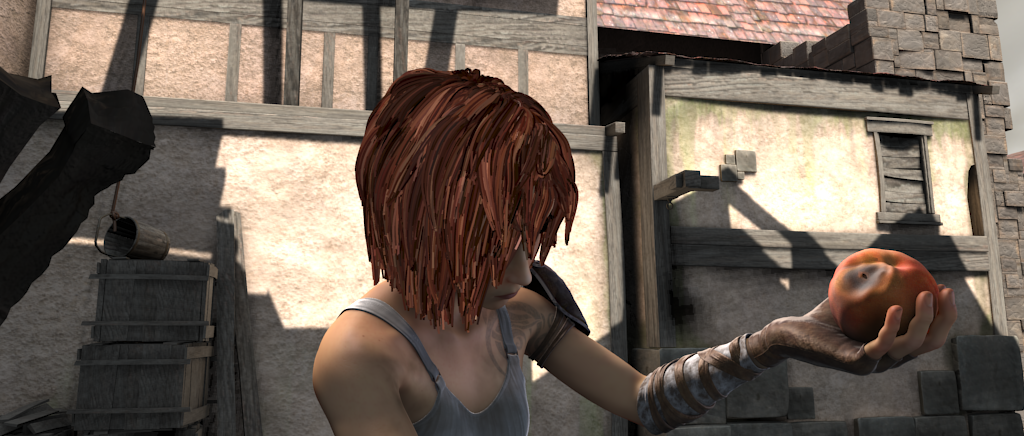

In [8]:
# EXAMPLE_IMAGE_URL = "https://dl.fbaipublicfiles.com/dinov2/images/example.jpg"

# image = load_image_from_url(EXAMPLE_IMAGE_URL)

#image = Image.open("woman-and-dog.jpg").convert("RGB")
image1 = Image.open("img/input/frame_0015.png").convert("RGB")
display(image1)

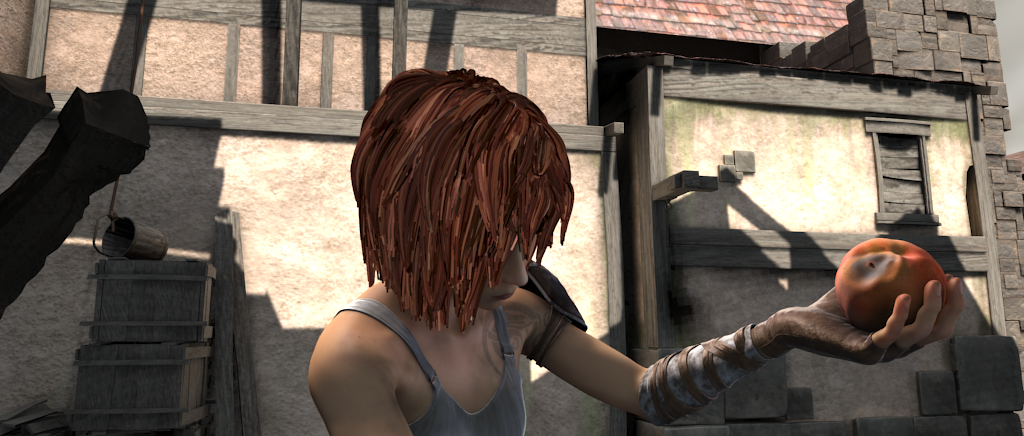

In [9]:
image2 = Image.open("img/input/frame_0016.png").convert("RGB")
display(image2)

## Semantic segmentation on sample image

In [10]:
import numpy as np

import dinov2.eval.segmentation.utils.colormaps as colormaps


DATASET_COLORMAPS = {
    "ade20k": colormaps.ADE20K_COLORMAP,
    "voc2012": colormaps.VOC2012_COLORMAP,
}


def render_segmentation(segmentation_logits, dataset):
    colormap = DATASET_COLORMAPS[dataset]
    colormap_array = np.array(colormap, dtype=np.uint8)
    segmentation_values = colormap_array[segmentation_logits + 1]
    return Image.fromarray(segmentation_values)


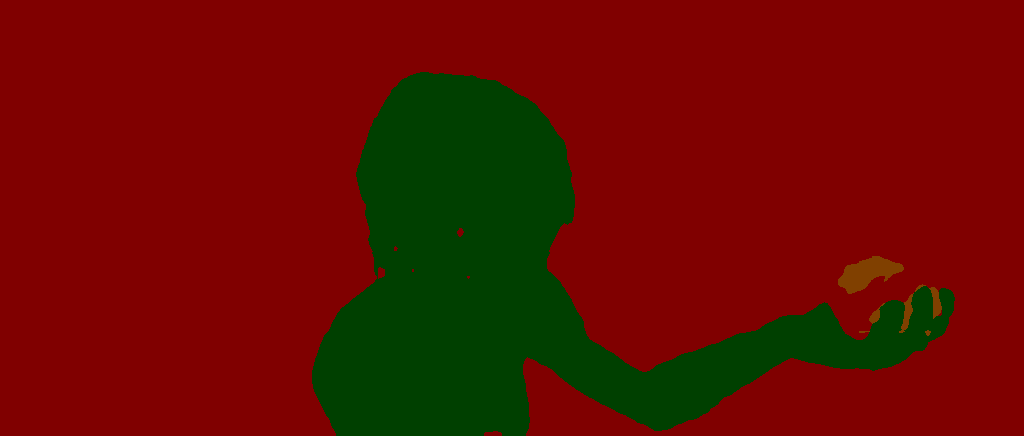

In [13]:
array1 = np.array(image1)[:, :, ::-1] # BGR
segmentation_logits1 = inference_segmentor(model, array1)[0]
segmented_image1 = render_segmentation(segmentation_logits1, HEAD_DATASET)
display(segmented_image1)

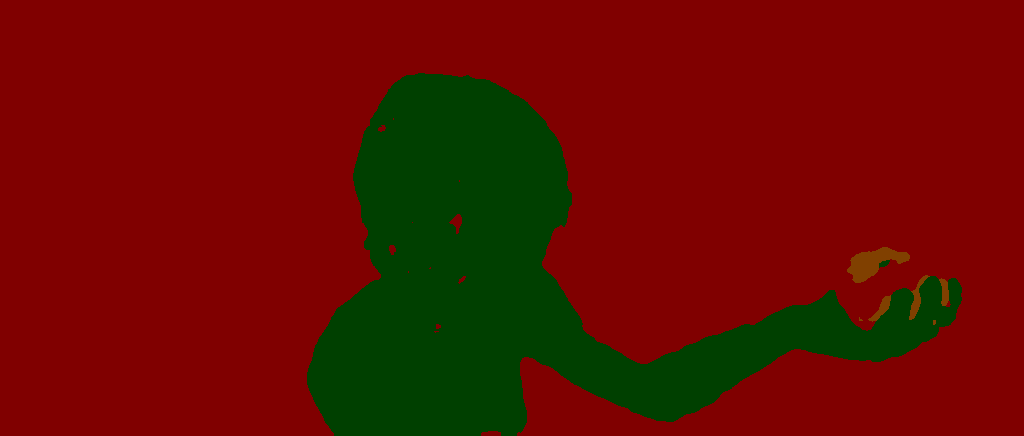

In [14]:
array2 = np.array(image2)[:, :, ::-1] # BGR
segmentation_logits2 = inference_segmentor(model, array2)[0]
segmented_image2 = render_segmentation(segmentation_logits2, HEAD_DATASET)
display(segmented_image2)

In [15]:
from torchvision.transforms import v2
transforms = v2.Compose([
    v2.ToTensor(),  # Convert to tensor, only needed if you had a PIL image
    v2.ToDtype(torch.float32),  # optional, most input are already uint8 at this point
    # ...
    v2.Resize(antialias=True, size=(224,224)),  # Or Resize(antialias=True)
    # ...
    #v2.ToDtype(torch.float32),  # Normalize expects float input
    #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

/home/allshama/miniconda3/envs/dinov2-gmflow/lib/python3.9/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/allshama/miniconda3/envs/dinov2-gmflow/lib/python3.9/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedba

In [16]:
def get_intermediate_layers_from_array(array1):
    image = torch.from_numpy(array1.copy()).permute(2,0,1).cuda()
    print(image.shape)
    image = transforms(image)
    print(image.shape)
    image = torch.unsqueeze(image, 0)
    print(image.shape)
    backbone_model(image)
    print(backbone_model.get_intermediate_layers(image)[0].shape)
    return image
image1 = get_intermediate_layers_from_array(array1)
image2 = get_intermediate_layers_from_array(array2)

torch.Size([3, 436, 1024])
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 256, 384])
torch.Size([3, 436, 1024])
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 256, 384])


In [17]:
# image2 = torch.from_numpy(array2.copy()).permute(2,0,1).cuda()
# print(image2.shape)
# image2 = transforms(image2)
# print(image2.shape)
# image2 = torch.unsqueeze(image2, 0)
# print(image2.shape)
# backbone_model(image2)
# print(backbone_model.get_intermediate_layers(image2)[0].shape)

In [48]:
# inference_segmentor(model, array, return_datasamples=True)

In [18]:
array1.shape

(436, 1024, 3)

In [19]:
def get_layers_mask(segmentation_logits, array):
    nlayers = np.unique(segmentation_logits)
    layers = np.zeros([nlayers.size, array.shape[0], array.shape[1]])
    print(nlayers)
    print(layers.shape)
    for i,_ in enumerate(nlayers):
        layers[i, :, :] = segmentation_logits == nlayers[i]
    print(layers)
    return layers
layers1 = get_layers_mask(segmentation_logits1, array1)
layers2 = get_layers_mask(segmentation_logits2, array2)

[ 0 15 16]
(3, 436, 1024)
[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
[ 0 15 16]
(3, 436, 1024)
[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0.

In [20]:
# nlayers2 = np.unique(segmentation_logits2)
# layers2 = np.zeros([nlayers2.size, array2.shape[0], array2.shape[1]])
# print(nlayers2)
# print(layers2.shape)
# for i,_ in enumerate(nlayers2):
#     layers2[i, :, :] = segmentation_logits2 == nlayers2[i]
# print(layers2)

In [21]:
def layer_to_pixel_values(layers):
    layers = np.moveaxis(layers, 0, -1)
    layers = layers.astype(np.uint8)
    layers = layers*255
    return layers
layers1 = layer_to_pixel_values(layers1)
layers2 = layer_to_pixel_values(layers2)

In [26]:
# layers2 = np.moveaxis(layers2, 0, -1)
# layers2 = layers2.astype(np.uint8)
# layers2 = layers2*255
# layers2

array([[[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       ...,

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]]

In [22]:
from PIL import Image

In [23]:
im = Image.fromarray(layers1)
im.save("img/output/frame_0015_seg.png")

In [24]:
im = Image.fromarray(layers2)
im.save("img/output/frame_0016_seg.png")

In [57]:
layers2.shape

In [25]:
type(layers2)

numpy.ndarray

## Modify original image using segmentation  

In [26]:
np.unique(segmentation_logits1)

array([ 0, 15, 16])

In [27]:
import numpy as np
import cv2

In [28]:
def modify_image_segmentation_based(img_name, segmentation_logits):
    image = Image.open(f"img/input/{img_name}.png").convert("RGB")
    imagen_modificada = np.copy(np.array(image).astype(np.uint8))
    coordenadas_objeto1 = np.where(segmentation_logits == 15)
    coordenadas_objeto2 = np.where(segmentation_logits == 16)
    for y, x in zip(coordenadas_objeto1[0], coordenadas_objeto1[1]):
        imagen_modificada[y, x] = np.clip(imagen_modificada[y, x] * 1.3, 0, 255)

    for y, x in zip(coordenadas_objeto2[0], coordenadas_objeto2[1]):
        imagen_modificada[y, x] = np.clip(imagen_modificada[y, x] + 20, 0, 255)
        
    cv2.imwrite(f"img/output/{img_name}_seg_steroids.png", imagen_modificada[:, :, ::-1])

In [29]:
modify_image_segmentation_based("frame_0015", segmentation_logits1)
modify_image_segmentation_based("frame_0016", segmentation_logits2)

In [165]:
window_name = 'image'
cv2.imshow(window_name, imagen_modificada[:, :, ::-1])
cv2.waitKey(0)
cv2.destroyAllWindows() 

In [90]:
fitype(image1)

## Join layers: Original + Segmentation

In [66]:
# 2 ndarrays expected
def save_joined_layers_tensor(layers_image, layers_seg, filename):
    tensor = torch.tensor(np.concatenate([layers_image, layers_seg], axis=2))
    torch.save(tensor, f"img/output/{filename}.pt")
save_joined_layers_tensor(array1, layers1, "frame_0015")
save_joined_layers_tensor(array2, layers2, "frame_0016")

In [26]:
layers.shape
HEAD_DATASET

In [33]:
segmented_image = render_segmentation(layers[3,:,:].astype(int), HEAD_DATASET)
display(segmented_image)

## Load pretrained segmentation model (Mask2Former)

In [8]:
import dinov2.eval.segmentation_m2f.models.segmentors

CONFIG_URL = f"{DINOV2_BASE_URL}/dinov2_vitg14/dinov2_vitg14_ade20k_m2f_config.py"
CHECKPOINT_URL = f"{DINOV2_BASE_URL}/dinov2_vitg14/dinov2_vitg14_ade20k_m2f.pth"

cfg_str = load_config_from_url(CONFIG_URL)
cfg = mmcv.Config.fromstring(cfg_str, file_format=".py")

model = init_segmentor(cfg)
load_checkpoint(model, CHECKPOINT_URL, map_location="cpu")
model.cuda()
model.eval()

## Semantic segmentation on sample image

In [ ]:
array = np.array(image)[:, :, ::-1] # BGR
segmentation_logits = inference_segmentor(model, array)[0]
segmented_image = render_segmentation(segmentation_logits, "ade20k")
display(segmented_image)